## Convolutional Autoencoder

### Set environment

In [0]:
!pip install tensorflow-gpu

In [0]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
#import keras
from tensorflow.keras.models import Model, Sequential, load_model 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, Activation
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from PIL import Image

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Architecture

#### Keras layers

In [0]:
# keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid')
# keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) 
# keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')

#### Batch normalization:

add the BatchNormalization transform immediately before the nonlinearity!

Orig paper: *Accelerating Deep Network Training by Reducing Internal Covariate Shift.*

example:

model.add(layers.Conv2D(64,(3,3), use_bias=False)) 

model.add(layers.BatchNormalization()) 

model.add(Activation("relu"))

In [0]:
input_img = Input(shape=(256, 256, 3)) 

# Encoder network
x = Conv2D(64,(9,9), dilation_rate = 2, use_bias = False, padding = 'same')(input_img) # strides = 2 OR dilation rate!
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPooling2D((2, 2), padding = 'same')(x) 

x = Conv2D(32,(5,5), dilation_rate = 2, use_bias = False, padding = 'same')(x) # strides = 2 OR dilation rate!
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPooling2D((2, 2), padding='same')(x) 

x = Conv2D(16,(3,3), use_bias = False, padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPooling2D((2, 2), padding = 'same')(x) 

encoded = Flatten()(x)

encoder = Model(input_img, encoded)
#encoder.summary()



# Decoder network
x = Reshape((32, 32, 16))(encoded) 

x = Conv2D(64,(3,3), use_bias = False, padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(32,(3,3), use_bias = False, padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(16,(3,3), use_bias = False, padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(3,(3,3), use_bias = False, padding = 'same')(x)
x = BatchNormalization()(x)
decoded = Activation("sigmoid")(x)
 

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')  # try 'adadelta': good for sparse data / binary_crossentropy
autoencoder.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 256, 64)      15552     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_16 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      51200     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128, 128, 32)      128 

### Image augmentation to tensors

In [0]:
image_data_dir = '/content/drive/My Drive/PhenoCAT/labeled_images'

image_size = 256 # All images will be resized to 
batch_size = 10

In [0]:
# Rescale and apply image augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 180,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

# results in tuples of (x, y) where x is a numpy array containing a batch of images 
# with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels.
train_generator = datagen.flow_from_directory(image_data_dir,                      
                                                target_size = (image_size, image_size), # default: 256
                                                color_mode='rgb', 
                                                batch_size = batch_size,
                                                class_mode = 'input', # when images identical to input images (autoencoders)
                                                # save_to_dir = 'path' saves augmented images 
                                                # save_prefix='augm_', 
                                                # save_format='png', 
                                                subset='training', # 'validation'
                                                interpolation='nearest') # 'bicubic', for re-sizing

validation_generator = datagen.flow_from_directory(image_data_dir,
                                                target_size = (image_size, image_size), # default: 256
                                                color_mode='rgb', 
                                                batch_size = batch_size, 
                                                class_mode = 'input',
                                                # save_to_dir = 'path' saves augmented images 
                                                # save_prefix='augm_', 
                                                # save_format='png', 
                                                subset='validation', # 'validation'
                                                interpolation='nearest') # 'bicubic', for re-sizing    


Found 2055 images belonging to 1 classes.
Found 513 images belonging to 1 classes.


### Train model

In [0]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
epochs = 50

print(steps_per_epoch,validation_steps)

205 51


In [0]:
# fits the model on batches with real-time data augmentation:
history = autoencoder.fit_generator(train_generator,
                                    steps_per_epoch = steps_per_epoch,
                                    epochs = epochs,
                                    validation_data = validation_generator,
                                    validation_steps = validation_steps)

# save model and architecture to single file
autoencoder.save("/content/drive/My Drive/Model_data/Conv_AE_v4.h5")
encoder.save("/content/drive/My Drive/Model_data/Conv_AE_v4_encoder.h5")

# autoencoder.save_weights("Conv_AE_v1_weights.h5")
# # save model to JSON
# autoencoder_json = autoencoder.to_json()
# with open("Conv_AE_v1.json", "w") as json_file:
#     json_file.write(autoencoder_json)
    
print("Saved model and weights")

Epoch 1/50
205/205 [==============================] - 51s 250ms/step - loss: 0.1956 - val_loss: 0.1469
Epoch 2/50
205/205 [==============================] - 45s 221ms/step - loss: 0.1506 - val_loss: 0.1161
Epoch 3/50
205/205 [==============================] - 46s 223ms/step - loss: 0.1152 - val_loss: 0.1054
Epoch 4/50
205/205 [==============================] - 46s 224ms/step - loss: 0.0867 - val_loss: 0.1477
Epoch 5/50
205/205 [==============================] - 45s 221ms/step - loss: 0.0647 - val_loss: 0.0560
Epoch 6/50
205/205 [==============================] - 46s 223ms/step - loss: 0.0477 - val_loss: 0.0486
Epoch 7/50
205/205 [==============================] - 45s 221ms/step - loss: 0.0348 - val_loss: 0.0331
Epoch 8/50
205/205 [==============================] - 45s 221ms/step - loss: 0.0251 - val_loss: 0.0229
Epoch 9/50
205/205 [==============================] - 46s 225ms/step - loss: 0.0180 - val_loss: 0.0151
Epoch 10/50
205/205 [==============================] - 45s 222ms/step - l

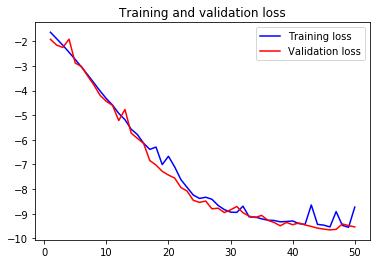

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']


x_epochs = range(1,epochs+1)

plt.figure()
plt.plot(x_epochs, np.log(loss), 'b', label = 'Training loss')
plt.plot(x_epochs, np.log(val_loss), 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.show()

plt.savefig('/content/drive/My Drive/Model_data/Loss_curve_Conv_AE_v4.pdf')

## Show 5 random images, compressed and reconstructed

In [0]:
num_images = 5
image_shape = (256, 256, 3)

path_to_folder = '/content/drive/My Drive/PhenoCAT/labeled_images/labeled_loose/'

image_list = os.listdir(path_to_folder)

image_list[0]

'CN-CP613_J06_T0001F020L01A01Z01C01_094.png'

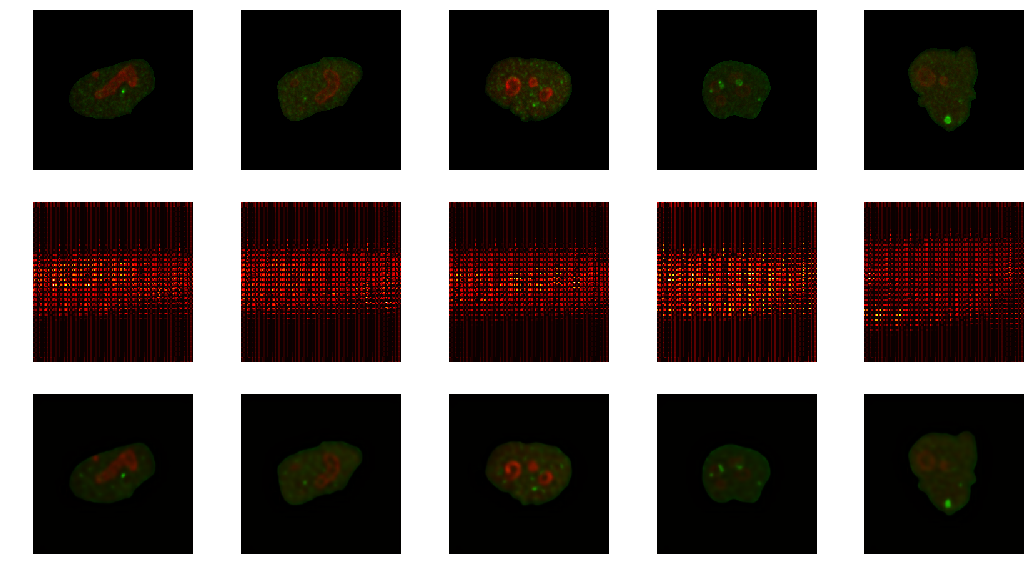

In [0]:
random_int = np.random.randint(0, len(image_list), num_images)


plt.figure(figsize=(18, 10))

for i in range(0, len(random_int)):
    curr_int = random_int[i]
    
    im_name = image_list[curr_int]
    im_path = path_to_folder + im_name
    real_image = image.load_img(im_path)

    img_tensor = image.img_to_array(real_image)/255
    img_tensor_ex = np.expand_dims(img_tensor, axis = 0)
    encoded_img = encoder.predict(img_tensor_ex) 
    new_im_size = int(np.sqrt(encoded_img.shape[1]))
    latent_image = encoded_img.reshape(new_im_size, new_im_size) 
   
    decoded_image_ex = autoencoder.predict(img_tensor_ex)
    decoded_image = np.squeeze(decoded_image_ex, axis = 0)
    
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(real_image)
    plt.axis('off') # ax.get_xaxis().set_visible(False)
    
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(latent_image, cmap = 'hot')
    plt.axis('off') # ax.get_xaxis().set_visible(False)
    
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_image)
    plt.axis('off') # ax.get_xaxis().set_visible(False)

